<a href="https://colab.research.google.com/github/kaazdes/Pegas_NN_Segment_color/blob/main/Pegas_Segment_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Description**

In [ ]:
# Рещение задачи сегментации изображений поля с посевами для целей навигации сельскохозяйственной машины ООО "Пегас Агро"
# Цель работы
# Создать прототип алгоритма (нейронной сети) для определения траектории движения колёсной машины типа «Туман-3»
# между рядами сельскохозяйственных культур, что совместно с системой подруливающего устройства
# позволит снизить повреждение растений при их обработке.

In [ ]:
# Постановка задачи:
# Входными данными для алгоритма должны быть изображения поля впереди машины по ходу её движения с проросшими
#  (растущими) сельскохозяйственными культурами, получаемые с цифровой фотокамеры (примеры рис.1)

In [ ]:
# Условный вариант обработки данных и представления результатов нейронной сетью должен соответствовать схеме рис.2

In [ ]:
# Поставленная задача решалась при следующих установленных библиотеках:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.4
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

# **2. Import & Functions**

## Import

In [ ]:
import math          # математический пакет
import random
# import struct        # Работа с байтами
import sys
import io            # операции ввода вывода
import numpy as np   # операции с матрицами
import os            #
from time import time

import matplotlib.pyplot as plt         # построеине графиков в листе Юпитера
%matplotlib inline
from matplotlib.ticker import (
    MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
sns.set()
import matplotlib as mpl

from sklearn.model_selection import train_test_split # инструменты для прогнозного анализа данных машинного обучения
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras import Input
from keras.preprocessing.image import ImageDataGenerator

import cv2
# import image
import copy
from google.colab import runtime

import seaborn as sns
from sklearn.metrics import confusion_matrix

from IPython.display import clear_output # очистка поля вывода в ячейку

# %tensorflow_version 2.x

import tensorflow as tf

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras import layers
from keras import Input

## Функции

In [ ]:
#@title mask_gen
# Функция генератор для чтения картинок из дирректории диска. Если читаются маски сохранённые в rgba дополнительно обработка
data_gen_args = dict(rotation_range=10.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale=1./255)
train_dir = '/content/sample_data/Data_Segment_Pegas/variant_5/train/'
def mask_gen(train_dir=train_dir, data_gen_args=data_gen_args, target_size=(256, 256), batch_size=32,  seed=2):
  ''' train_dir: директория хранения картинок датасета
      data_gen_args: параметры для ImageDataGenerator
      target_size: размеры в которые преобразуются исходные картинки = (256, 256)
      batch_size:  кол-во картинок вычиваемых за раз = 32
      seed: для одинаковой инициализации генераторов картинок для train и valid при из изменеии на лету'''
  mask_datagen  = ImageDataGenerator(**data_gen_args)
  mask_generator = mask_datagen.flow_from_directory(
      directory=train_dir,
      target_size=target_size,
      color_mode='rgba',
      classes=['mask'],
      class_mode=None,
      batch_size=batch_size,
      interpolation='bilinear',
      seed=seed
  )
  while True:
    batch = next(mask_generator)
    batch = batch[:,:,:,3]
    batch[batch <= 0.5] = 0
    batch[batch >  0.5] = 1
    mask_image = to_categorical(batch, num_classes=2)
    yield mask_image


In [ ]:
#@title RGB
# Работа с масками для наложения их на фото
def to_rgb1(im):
    # im: ndarray in gray
    # out to RGB format
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im*255
    ret[:, :, 1] = im*255
    ret[:, :, 2] = im*255
    return ret
def to_mask_color(im):
    # im: ndarray in segment 0, 1
    # out to RGB format magenta
    w, h = im.shape
    ret = np.full(shape=(w, h, 3), fill_value=255 , dtype=np.uint8)
    ret[mask_m ==1, 0] = 255
    ret[mask_m ==1, 1] = 0
    ret[mask_m ==1, 2] = 255
    return ret

def mix_im_mask(im, mask):
  ''' Накладывает на входное изображение переданное в виде массива gray  маску их сегментации 0/1/2...'''
  if im.ndim < 3:
    im_rgb = to_rgb1(im) # gray array image to RGB format array
  else:
    im_rgb = im
  mask_rgb = to_mask_color(mask)
  mix = cv2.addWeighted(im_rgb, 0.7, mask_rgb, 0.2, 0)
  return mix

# **3. Initialization**

In [ ]:
#@title Global Varible
SET_IM_SIZE = (128, 256) # Размер загружаемой картинки
seed = 2  # Постоянный рандом
BATCH_SIZE = 32 # Размер пакета для обучения нейронной сети
NUM_CLASSES = 2 # Количесво классов сегментов

In [ ]:
#@title Set_directory
# Директории хранения файлов
# Требуется в дирреткории гугл диска создать каталог "Диск: /Data_Colab/Data_Segment_Pegas/variant_5"  и далее структура папок train, valid ...
place = 'local' # or local  google
part_str = 'variant_5'
if place == 'local':
  main_path = '/content/sample_data/' + part_str
  train_dir = main_path + '/train/'   # синтезированные данные для обучения сети
  val_dir   = main_path + '/valid/'
  test_dir  = main_path + '/test/'
  real_dir  = main_path + '/real/'
  path_best_model = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str +'/my_model_Segment.h5' #  где будет лежать лучшая модель
elif place == 'google':
  main_path = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str
  train_dir = main_path + '/train/'   # синтезированные данные для обучения сети
  val_dir   = main_path + '/valid/'
  test_dir  = main_path + '/test/'
  real_dir  = main_path + '/real/'
  path_best_model = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str + '/my_model_Segment.h5' #  где будет лежать лучшая модель

# Сведения о аппаратной платформе выполения кода
# Работа с командной строкой Ubuntu открытой сессии googlegolab
# https://github.com/sozykin/asozykin.ru/blob/master/_posts/2019-02-18-Colab-Linux-Commands.md

!ls sample_data
!ls /proc/driver/nvidia/gpus/
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md
0000:00:04.0
Model: 		 Unknown
IRQ:   		 11
GPU UUID: 	 GPU-c7cf65fc-531a-da8a-ba23-c866c491d091
Video BIOS: 	 90.04.a7.00.01
Bus Type: 	 PCI
DMA Size: 	 47 bits
DMA Mask: 	 0x7fffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
GPU Excluded:	 No


In [ ]:
#@title Copy dataset to virt machine
# Копируем Dataset в архиве из гугл диска в сессию googlegolab используя команднуд строку ubuntu
if place == 'local':
  # cp -a /content/drive/MyDrive/Data_Colab/Data_Segment_Pegas /content/sample_data
  !rsync -r --info=progress2 /content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/variant_5/  /content/sample_data/

    816,411,244 100%   44.13MB/s    0:00:17 (xfr#11, to-chk=0/12)


In [ ]:
#@title  Unboxing
# Распаковка архива dataset
!unrar x /content/sample_data/variant_5.rar /content/sample_data/
!ls /content/sample_data/variant_5/train/

Выходные данные были обрезаны до нескольких последних строк (5000).
Extracting  /content/sample_data/variant_5/valid/image/image0020.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0021.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0022.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0023.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0024.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0025.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0026.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0027.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0028.png      56%  OK 
Extracting  /content/sample_data/variant_5/valid/image/image0029.png      56%  OK 
Extracting  

In [ ]:
# Если хотим удалить папку с файлами на диске:
# !rmdir --ignore-fail-on-non-empty /content/sample_data/variant_5.rar

# **4. Data visualization**

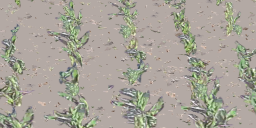

In [ ]:
# Проверка чтения файлов из дирректории
import cv2
im_visu = 'image/image0003.png'
ms_visu = 'mask/image0003.png'
image = cv2.imread(train_dir + im_visu)
# cv2.imshow(image)
from google.colab.patches import cv2_imshow
cv2_imshow(image)
# cv2.waitKey(0)

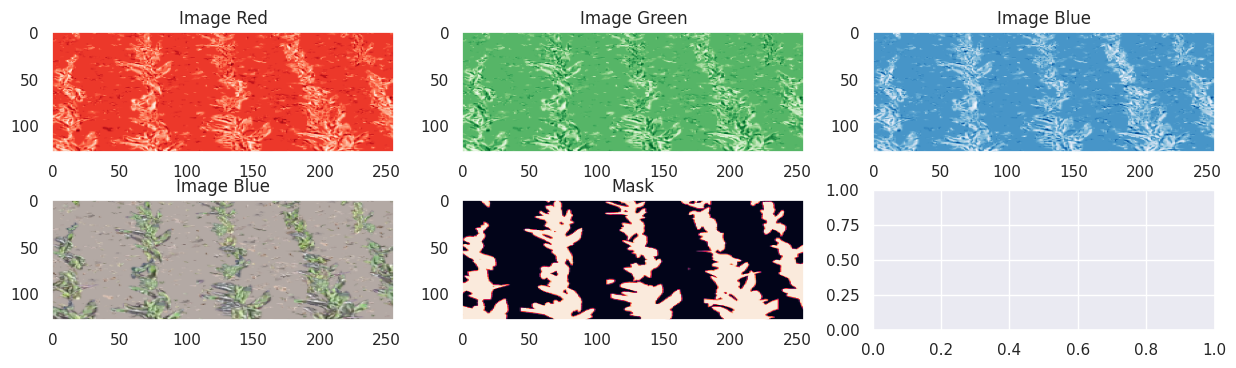

In [ ]:
# Чтение/ отображение  фото и масок из набора
image = tf.keras.preprocessing.image.load_img(path=train_dir + im_visu, color_mode='rgb') # grayscale
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
fig, ax = plt.subplots(2, 3, figsize=(15, 4))
im1 = ax[0, 0].imshow(input_arr[0,:,:,0], aspect=0.7,cmap='Reds') # gray
ax[0, 0].grid(False)
ax[0, 0].set_title('Image Red')

im1 = ax[0, 1].imshow(input_arr[0,:,:,1], aspect=0.7,cmap='Greens') # gray
ax[0, 1].grid(False)
ax[0, 1].set_title('Image Green')

im1 = ax[0, 2].imshow(input_arr[0,:,:,2], aspect=0.7,cmap='Blues') # gray
ax[0, 2].grid(False)
ax[0, 2].set_title('Image Blue')

im1 = ax[1, 0].imshow(input_arr[0,:,:,:]/255, aspect=0.7) # gray
ax[1, 0].grid(False)
ax[1, 0].set_title('Image Blue')

mask = tf.keras.preprocessing.image.load_img(path=train_dir + ms_visu, color_mode='rgba')
input_arr = tf.keras.preprocessing.image.img_to_array(mask)
input_arr = np.array([input_arr])  # Convert single image to a batch.
im2 = ax[1, 1].imshow(input_arr[0,:,:,3], aspect=0.7)
ax[1, 1].grid(False)
ax[1, 1].set_title('Mask');

In [ ]:
#@title Check train_generator
print('Train directory : ', train_dir)
# IMAGE generator
# data_gen_args = dict(rescale=1./255)
data_gen_args = dict(rotation_range=10.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale=1./255) # 1./255
# featurewise_center=True, featurewise_std_normalization=True,
image_datagen = ImageDataGenerator(**data_gen_args) # генератор данных картинок

# IMAGE generator
image_generator = image_datagen.flow_from_directory(
    directory=train_dir,
    color_mode='rgb',
    target_size=SET_IM_SIZE,
    classes=['image'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)
# MASK generator
mask_generator = mask_gen(train_dir=train_dir, data_gen_args=data_gen_args, target_size=SET_IM_SIZE, seed=seed)

train_generator = zip(image_generator, mask_generator) # Созданный генератор картинок и масок

# Поверка работы генератора
ch = next(train_generator)
im_batch = ch[0]
ms_batch = ch[1]
print(im_batch.shape, ' Image batch')
print(ms_batch.shape, ' Mask  batch')

Train directory :  /content/sample_data/variant_5/train/
Found 4096 images belonging to 1 classes.
Found 4096 images belonging to 1 classes.
(32, 128, 256, 3)  Image batch
(32, 128, 256, 2)  Mask  batch


In [ ]:
#@title Check valid_generator
# Для валидации
data_gen_args_valid = dict(rescale=1./255)
image_datagen_val = ImageDataGenerator(**data_gen_args_valid) # генератор данных картинок
print('Validation directory : ', val_dir)

image_generator_val = image_datagen_val.flow_from_directory(
    directory=val_dir,
    color_mode='rgb',
    target_size=SET_IM_SIZE,
    classes=['image'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)
mask_generator_val = mask_gen(train_dir=val_dir, data_gen_args=data_gen_args_valid, target_size=SET_IM_SIZE, seed=seed)
valid_generator = zip(image_generator_val, mask_generator_val) # Созданный генератор картинок и масок
# Поверка работы генератора
chv = next(valid_generator)
im_batchv = chv[0]
ms_batchv = chv[1]
print(im_batchv.shape, ' Image batch')
print(ms_batchv.shape, ' Mask  batch')

Validation directory :  /content/sample_data/variant_5/valid/
Found 300 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
(32, 128, 256, 3)  Image batch
(32, 128, 256, 2)  Mask  batch


## Displaying a photo from the generator

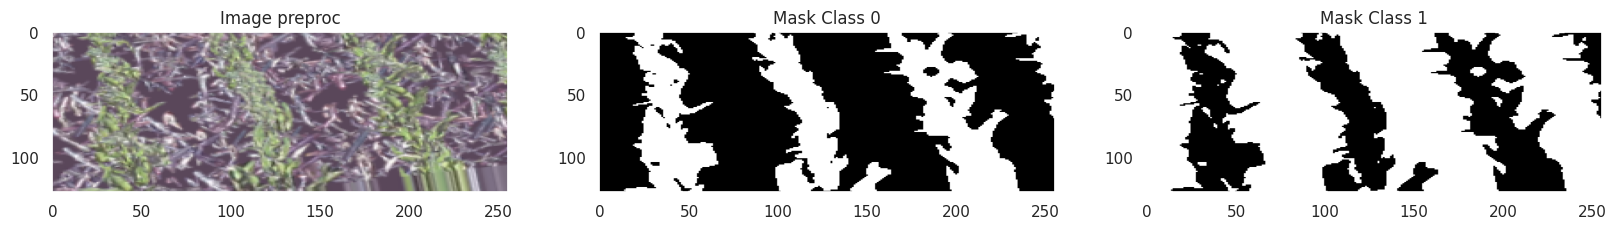

In [ ]:
image_vis = 10
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
im1 = ax[0].imshow(im_batch[image_vis,:,:,:], aspect=0.7, cmap='gray')
ax[0].set_title('Image preproc')
ax[0].grid(False)
im2 = ax[1].imshow(ms_batch[image_vis,:,:,0], aspect=0.7, cmap='binary')
ax[1].set_title('Mask Class 0')
ax[1].grid(False)
im3 = ax[2].imshow(ms_batch[image_vis,:,:,1], aspect=0.7, cmap='binary')
ax[2].set_title('Mask Class 1')
ax[2].grid(False)

In [ ]:
# https://stackoverflow.com/questions/31877353/overlay-an-image-segmentation-with-numpy-and-matplotlib
# Наложение масок на изображение

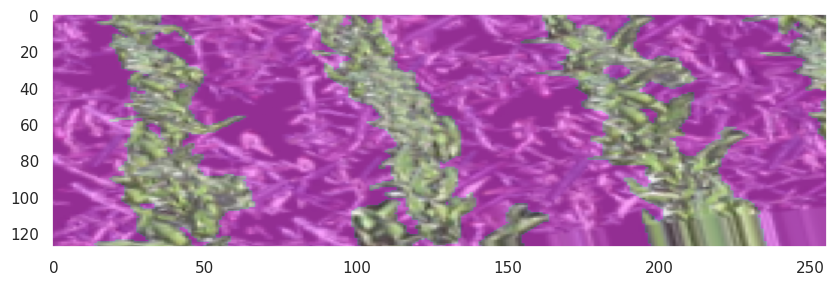

In [ ]:
# Наложеине Pink маски в matplotlib отображении
image_m = im_batch[image_vis,:,:,:]
mask_m = ms_batch[image_vis,:,:,0]
mask_m = mask_m * 1
fig = plt.subplots(figsize=(10, 4), dpi=100)
plt.imshow(image_m,  cmap='gray', aspect=0.6)
plt.grid(False)
plt.imshow(mask_m, cmap='cool', aspect=0.6, alpha=0.35 * mask_m) #

True

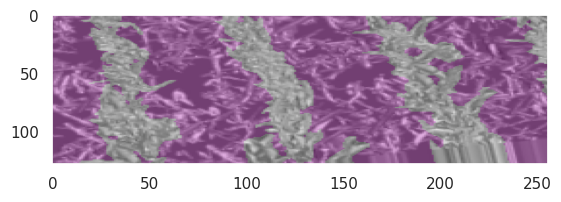

In [ ]:
res = mix_im_mask(image_m[:,:,0], mask_m)
plt.imshow(res, aspect=0.6); plt.grid(False)
cv2.imwrite('/content/sample_data/' +"filename.png", res)

# **5. Synthesis of neural networks (versions)**

In [ ]:
#@title Functions
def block(inp_x=tf.keras.Input(shape=(128, 256, 3), dtype = 'float32', name='inp_data_frame'),
          filters=(8, 8),
          inp_reduce=True,
          name='Bl_'):
  if inp_reduce==True:
    inp_x = layers.MaxPooling2D((2, 2), name=name+'_1')(inp_x)
  x = layers.Conv2D(filters[0], (2, 2), padding='same', activation='relu', name=name+'_2') (inp_x)
  x = layers.BatchNormalization(name=name+'_3')(x)
  x = layers.Conv2D(filters[1], (2, 2), padding='same', activation='relu', name=name+'_4') (x)
  block_out = layers.BatchNormalization(name=name+'_5')(x) # (256, 256, 8)
  return block_out

def block_up(inp_x=    tf.keras.Input(shape=(None, 128, 256, 3), dtype = 'float32', name='inp_data_frame'),
             back_link=tf.keras.Input(shape=(None, 128, 256, 3), dtype = 'float32', name='inp_data_frame'),
             name='Up_'):
  filter_back = back_link.shape[3]
  x = layers.Conv2DTranspose(filter_back, (2, 2),
                             strides=(2, 2),
                             padding='same',
                             activation='relu',
                             name=name+'_1') (inp_x)
  x = layers.BatchNormalization(name=name + '_2')(x)
  x = layers.concatenate([x, back_link], name= name + '_3') # (16, 16, 256 = 128 + 128)
  x = layers.Conv2D(filter_back, (2, 2), padding='same', activation='relu', name=name + '_4') (x)
  x = layers.BatchNormalization(name=name + '5')(x)
  x = layers.Conv2D(filter_back / 2, (2, 2), padding='same', activation='relu', name=name + '_6' ) (x)
  block_out = layers.BatchNormalization(name=name + '_7')(x) # (16, 16, 64)
  return block_out

def block_up_without_link(inp_x=tf.keras.Input(shape=(None, 128, 256, 3), dtype = 'float32', name='inp_data_frame'),
                          filter=(8, 16),
                          name='Up_'):

  x = layers.Conv2DTranspose(filter[1], (2, 2),
                              strides=(2, 2),
                              padding='same',
                              activation='relu',
                              name=name+'_1') (inp_x)
  x = layers.BatchNormalization(name=name + '_2')(x)
  x = layers.Conv2D(filter[0], (2, 2), padding='same', activation='relu', name=name + '_4') (x)
  x = layers.BatchNormalization(name=name + '5')(x)
  return x

### **SegNet model_1**

In [ ]:
# Структру сети

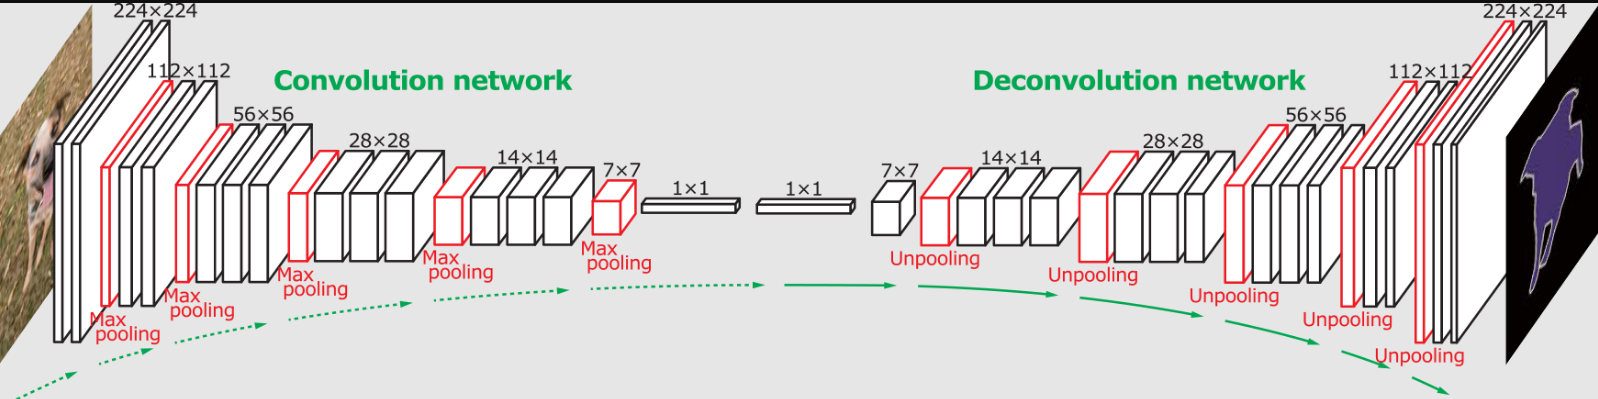

In [ ]:
#@title model_01 SegNet-Segment auto set filters
tf.keras.backend.clear_session() # сбросить состояния меодели в памяти
def get_model_FCN_Segment(filters=[(16,32), (64,128), (256, 512)], im_size=SET_IM_SIZE + (3,)):
  # filters = filters
  input_l = Input(shape=im_size, dtype = 'float32', name='data_frame')

  b = input_l # input_l
  inp_reduce=False
  arr_level = []
  # Down chain
  for i in range(len(filters)):
    if i!=0:
      inp_reduce=True
    name = name =f'Bl_{i+1}'
    if i==len(filters)-1:
      name=f'bottom_{i+1}'
    b = block(inp_x=b, filters=filters[i], inp_reduce=inp_reduce, name=name)
    arr_level.append(b)
  # Up Chain
  v = arr_level[len(filters) - 1]
  for i in range(len(filters)-2, -1, -1):
    print('step i = ', i)
    if i == (len(filters)-2):
      print('Да')
      v = b
    else:
      v = v
    filt = filters
    filt.reverse()
    print(filt[i])
    v = block_up_without_link(inp_x=v, filter= filt[i] , name=f'u_{i+1}')

  out = layers.Conv2D(2, (2, 2), padding='same', activation='softmax', name='out_mask') (v)

  model = Model(input_l, out)
  return model
model_1 = get_model_FCN_Segment(filters = [(8,16), (32,64), (128, 256)], im_size=SET_IM_SIZE + (3,))
model_1.summary(show_trainable=False)

step i =  1
Да
(32, 64)
step i =  0
(8, 16)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_frame (InputLayer)     [(None, 128, 256, 3)]     0         
                                                                 
 Bl_1_2 (Conv2D)             (None, 128, 256, 8)       104       
                                                                 
 Bl_1_3 (BatchNormalization)  (None, 128, 256, 8)      32        
                                                                 
 Bl_1_4 (Conv2D)             (None, 128, 256, 16)      528       
                                                                 
 Bl_1_5 (BatchNormalization)  (None, 128, 256, 16)     64        
                                                                 
 Bl_2_1 (MaxPooling2D)       (None, 64, 128, 16)       0         
                                                                 
 Bl_2_2 (Conv2D) 

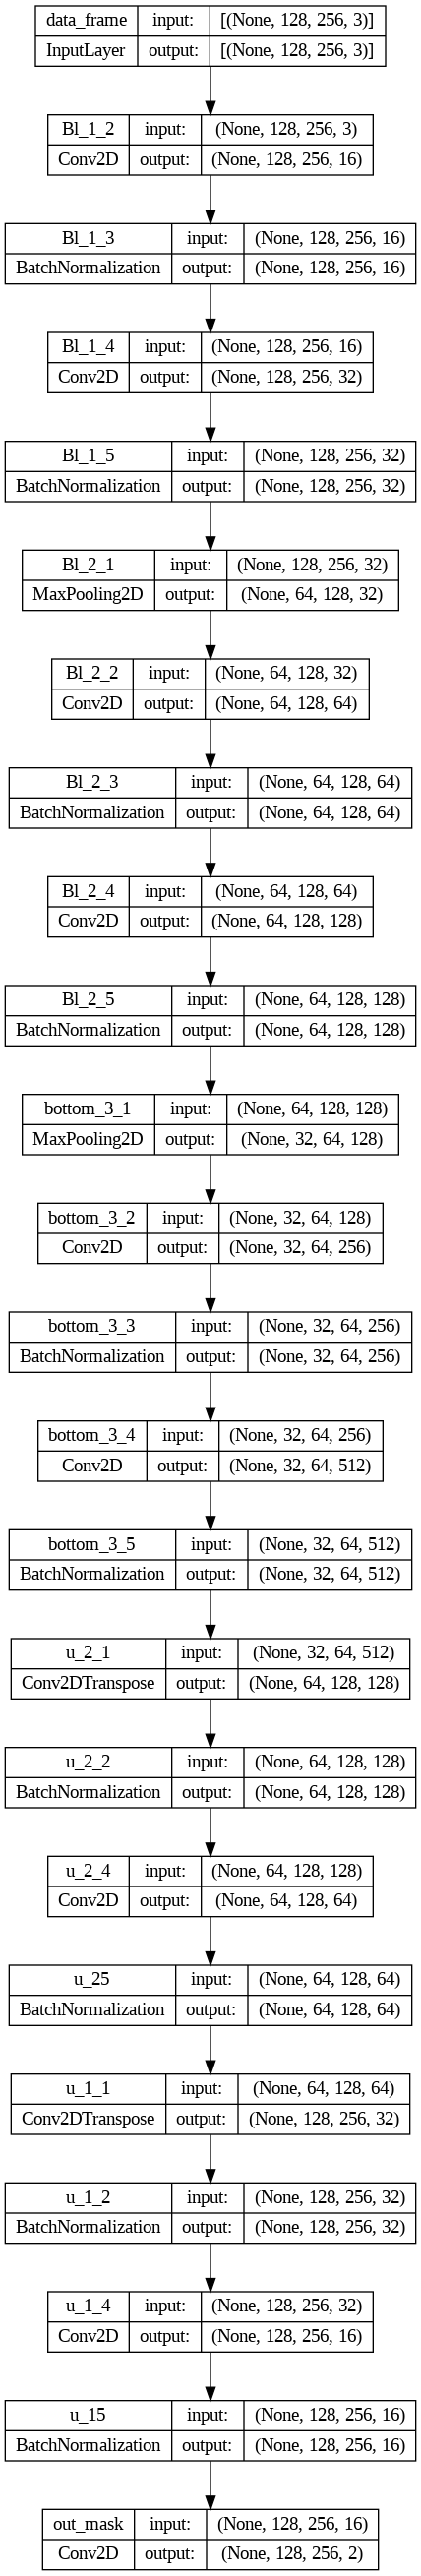

In [ ]:
# Построение графа модели
from keras.utils import plot_model
struct_model_pict = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str +'/model_struct_FCN_model.png'
plot_model(model_1, show_shapes=True, to_file=struct_model_pict)

### **U-net model_2**

In [ ]:
# Структура сети U-net

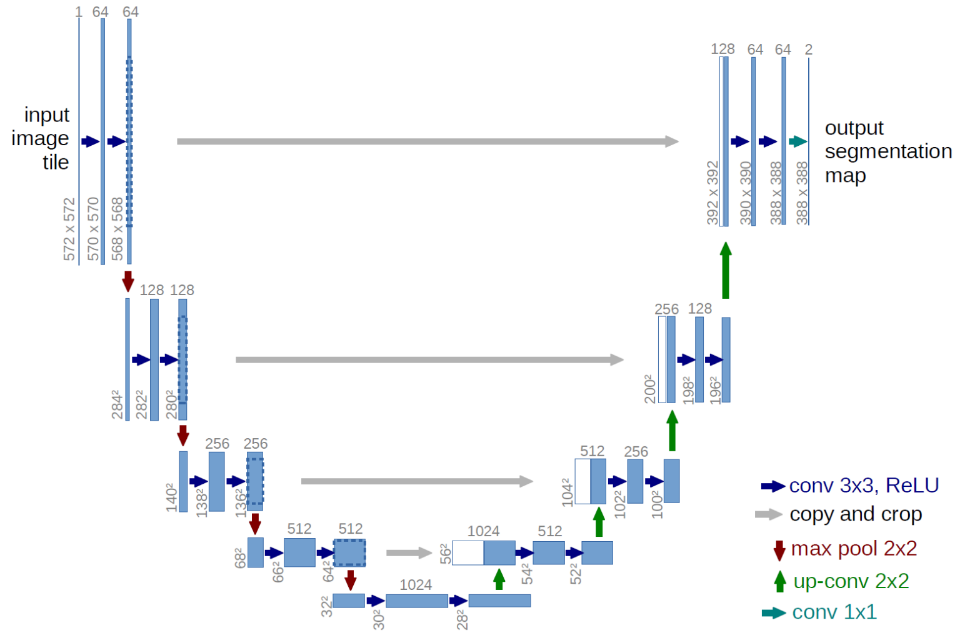

In [ ]:
#@title model_2 U-net Only manual
# https://www.bizkit.ru/2020/01/09/16203/
tf.keras.backend.clear_session() # сбросить состояния меодели в памяти

inp = Input(shape=(128, 256, 3), dtype = 'float32', name='data_frame')

# Block 1
x = layers.Conv2D(8, (2, 2), padding='same', activation='relu') (inp)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(8, (2, 2), padding='same', activation='relu', name='') (x)
b1out = layers.BatchNormalization()(x) # (128, 256, 8)

# Block 2
x = layers.MaxPooling2D((2, 2)) (b1out)
x = layers.Conv2D(8, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (2, 2), padding='same', activation='relu', name='b2out') (x)
b2out = layers.BatchNormalization()(x) # (64, 128, 16)

# Block 3
x = layers.MaxPooling2D((2, 2)) (b2out)
x = layers.Conv2D(16, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (2, 2), padding='same', activation='relu', name='b3out') (x)
b3out = layers.BatchNormalization()(x) # (32, 64, 32)

# Block 4
x = layers.MaxPooling2D((2, 2)) (b3out)
x = layers.Conv2D(32,  (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (2, 2), padding='same', activation='relu') (x)
b4out = layers.BatchNormalization()(x) # (16, 32, 64)
# ******

# Block 5
x = layers.MaxPooling2D((2, 2)) (b4out)
x = layers.Conv2D(64, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (2, 2), padding='same', activation='relu', name='b5out') (x)
b5out = layers.BatchNormalization()(x) # (8, 16, 128)

# Block 6
x = layers.MaxPooling2D((2, 2)) (b5out)
x = layers.Conv2D(128, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (2, 2), padding='same', activation='relu', name='b6out') (x)
b6out = layers.BatchNormalization()(x) # (4, 8, 256)
# ************
# UP1
x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu') (b6out)
x = layers.BatchNormalization()(x)
x = layers.concatenate([x, b5out]) # (8, 16, 256 = 128 + 128)
x = layers.Conv2D(128, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x) # (8, 16, 64)
# UP2
x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.concatenate([x, b4out]) # (16, 32, 128 = 64 + 64)
x = layers.Conv2D(64, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x) # (16, 32, 32)
# UP3
x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.concatenate([x, b3out]) # (32, 64, 64 = 32 + 32)
x = layers.Conv2D(32, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x) # (32, 64, 16)
# UP4
x = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.concatenate([x, b2out]) # (64, 128, 32 = 16 + 16)
x = layers.Conv2D(16, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(8, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x) # (64, 128, 8)
# UP5
x = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
x = layers.concatenate([x, b1out]) # (128, 256, 16 = 8 + 8)
x = layers.Conv2D(8, (2, 2), padding='same', activation='relu') (x)
x = layers.BatchNormalization()(x)
out = layers.Conv2D(2, (2, 2), padding='same', activation='softmax') (x)

model_2 = Model(inp, out)
model_2.summary(show_trainable=True)

In [ ]:
#@title model 2 U-net manual set filters
# https://www.bizkit.ru/2020/01/09/16203/
tf.keras.backend.clear_session() # сбросить состояния меодели в памяти
filters = [(8, 16),
           (16, 32),
           (32, 64),
           (64, 128),
           (128, 256),
           (256, 512)]
inp = Input(shape=(128, 256, 3), dtype = 'float32', name='data_frame')
b1 = block(inp_x=inp, filters=filters[0], inp_reduce=False, name='Bl_1')
b2 = block(inp_x=b1,  filters=filters[1],   name='Bl_2')
b3 = block(inp_x=b2,  filters=filters[2],  name='Bl_3')
b4 = block(inp_x=b3,  filters=filters[3],  name='Bl_4')
b5 = block(inp_x=b4,  filters=filters[4], name='Bl_5')
deep_part = block(inp_x=b5, filters=filters[5],  name='Deep_P_')
u5 = block_up(inp_x=deep_part, back_link=b5, name='u5')
u4 = block_up(inp_x=u5, back_link=b4, name='u4')
u3 = block_up(inp_x=u4, back_link=b3, name='u3')
u2 = block_up(inp_x=u3, back_link=b2, name='u2')
u1 = block_up(inp_x=u2, back_link=b1, name='u1')

out = layers.Conv2D(2, (2, 2), padding='same', activation='softmax', name='out_mask') (u1)

model_2 = Model(inp, out)
model_2.summary(show_trainable=False)

In [ ]:
#@title model 2 U-net auto set filters
def get_model_Unet(filters=[(16,32), (64,128), (256, 512)], im_size=SET_IM_SIZE + (3,)):
  # filters = filters
  tf.keras.backend.clear_session() # сбросить состояния меодели в памяти
  input_l = Input(shape=im_size, dtype = 'float32', name='data_frame')

  b = input_l # input_l
  inp_reduce=False
  arr_level = []
  # Down chain
  for i in range(len(filters)):
    if i!=0:
      inp_reduce=True
    name = name =f'Bl_{i+1}'
    if i==len(filters)-1:
      name=f'bottom_{i+1}'
    b = block(inp_x=b, filters=filters[i], inp_reduce=inp_reduce, name=name)
    arr_level.append(b)
  # Up Chain
  v = arr_level[len(filters) - 1]
  for i in range(len(filters)-2, -1, -1):
    if i == (len(filters)-2):
      print('Да')
      v = b
    else:
      v = v
    v = block_up(inp_x=v, back_link=arr_level[i], name=f'u_{i+1}')

  out = layers.Conv2D(2, (2, 2), padding='same', activation='softmax', name='out_mask') (v)

  model = Model(input_l, out)
  return model
model_2 = get_model_Unet(filters = [(16,32), (32,64), (64, 128)], im_size=SET_IM_SIZE + (3,))
model_2.summary(show_trainable=False)

Да
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data_frame (InputLayer)        [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Bl_1_2 (Conv2D)                (None, 128, 256, 16  208         ['data_frame[0][0]']             
                                )                                                                 
                                                                                                  
 Bl_1_3 (BatchNormalization)    (None, 128, 256, 16  64          ['Bl_1_2[0][0]']                 
                                )                                                          

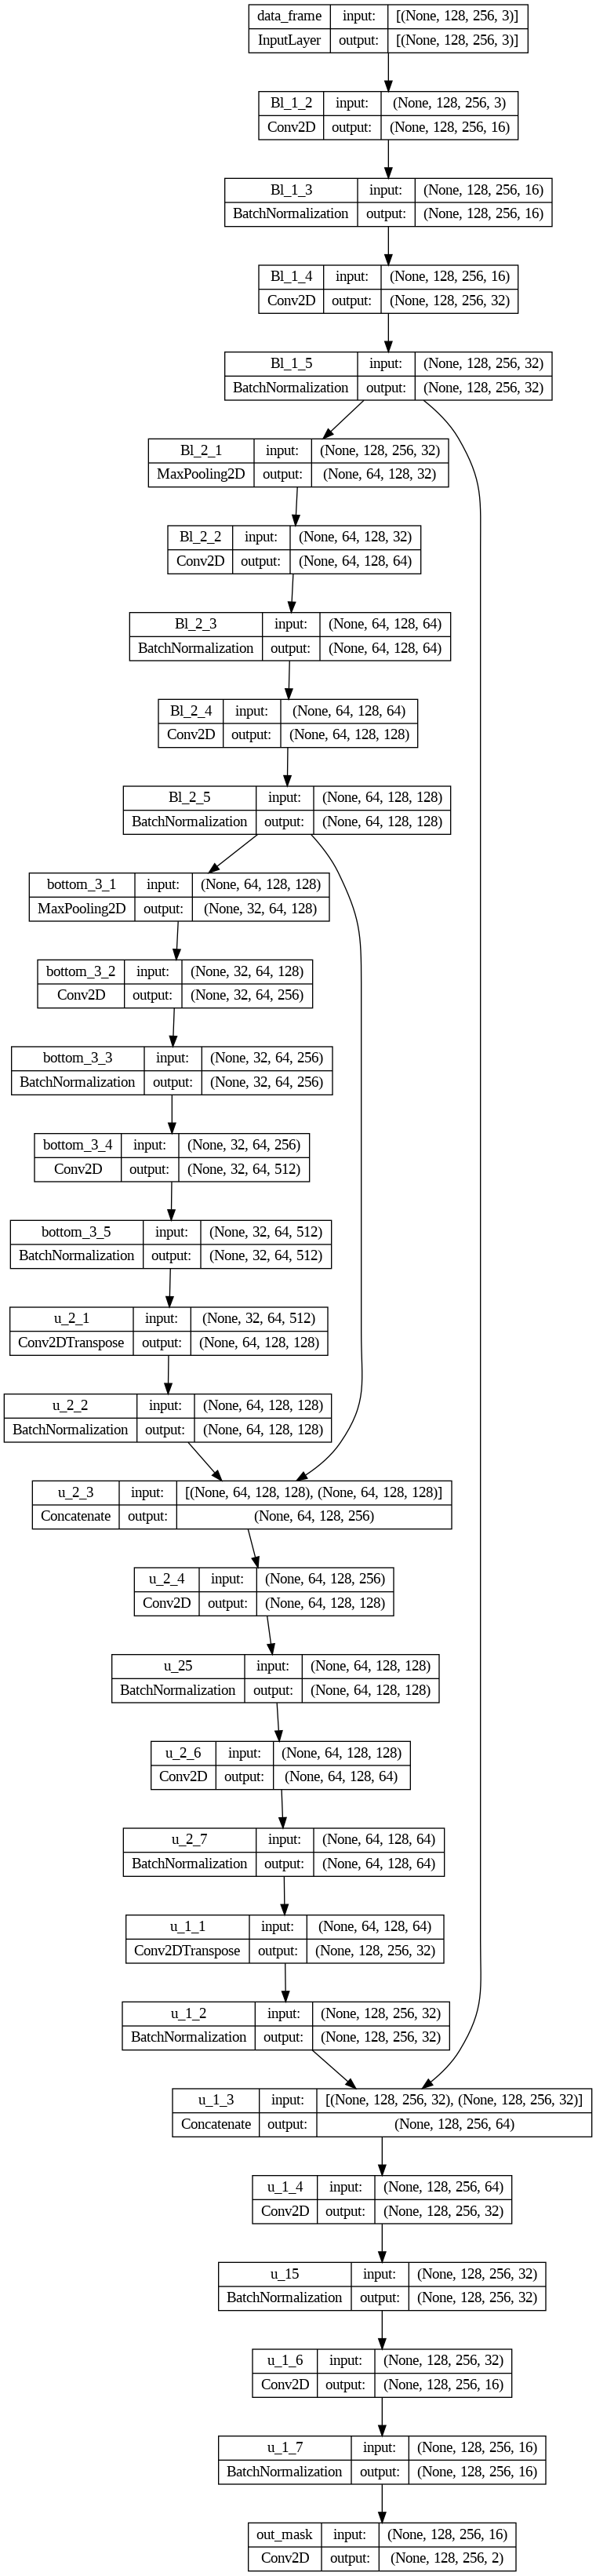

In [ ]:
# Построение графа модели
from keras.utils import plot_model
struct_model_pict = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str +'/model_struct_U_net.png'
plot_model(model_2, show_shapes=True, to_file=struct_model_pict)

### **SegNet based on ResNet model_3**

In [ ]:
#@title model 3 SegNet based in ResNet
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
tf.keras.backend.clear_session() # сбросить состояния меодели в памяти
def get_model_like_Unet(filter_in=8, filters_arr=[32, 64]):

  filter_arr = filters_arr
  inp_filter = filter_in
  ### [First half of the network: downsampling inputs] ###

  inp = keras.Input(shape=SET_IM_SIZE + (3,), dtype = 'float32', name='inp_data_frame')

  # Entry Block
  x = layers.Conv2D(inp_filter, (3, 3), strides=2, padding='same', activation='relu') (inp)
  x = layers.BatchNormalization()(x)
  previous_block_activation = x

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in filter_arr:
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    residual = layers.Conv2D(filters, (1,1), strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x

  ### [Second half of the network: upsampling inputs] ###

  for filters in filter_arr[::-1]:
    x = layers.Conv2DTranspose(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  # Exit Block
  x = layers.Conv2DTranspose(inp_filter, (3, 3), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.UpSampling2D((2, 2))(x)

  out = layers.Conv2D(NUM_CLASSES, (3, 3), padding='same', activation='softmax') (x)
  model = Model(inp, out)
  return model



model_3 = get_model_like_Unet(filter_in=8, filters_arr= [8, 32, 64])
model_3.summary(show_trainable=True)

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 inp_data_frame (InputLayer)    [(None, 128, 256, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 64, 128, 8)   224         ['inp_data_frame[0][0]']         Y          
                                                                                                             
 batch_normalization (BatchNorm  (None, 64, 128, 8)  32          ['conv2d[0][0]']                 Y          
 alization)                                                                                              

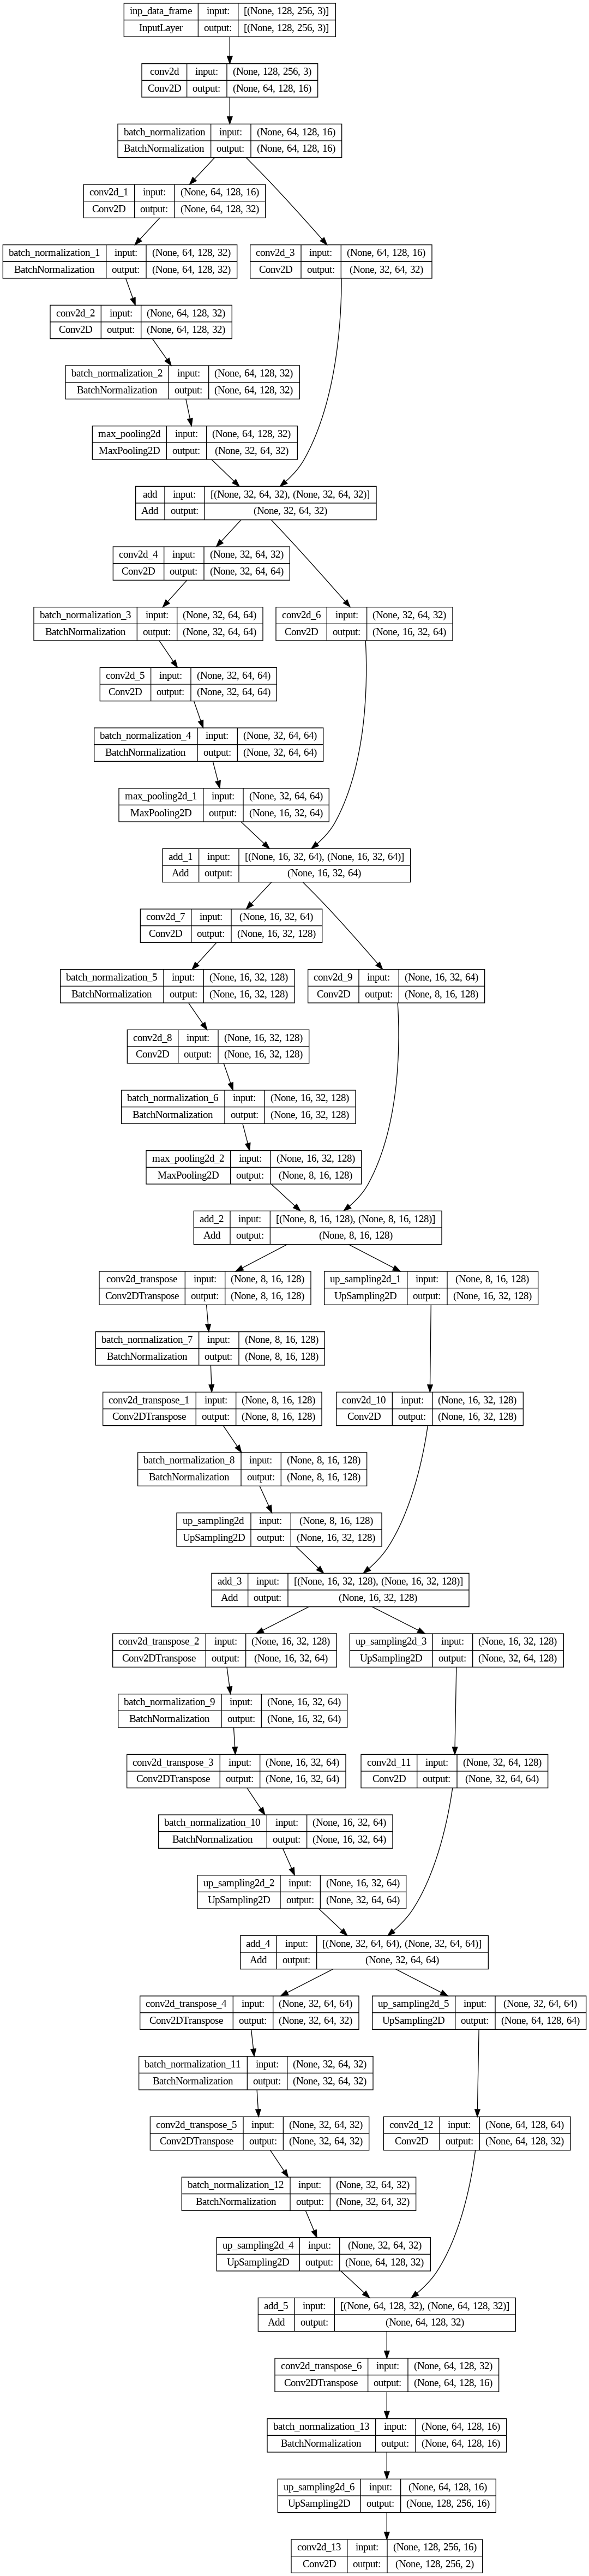

In [ ]:
# Построение графа модели
from keras.utils import plot_model
struct_model_pict = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str +'/model_struct_UnetLike.png'
plot_model(model_3, show_shapes=True, to_file=struct_model_pict)

### **DeepLab_V3_Plus model_4**


In [ ]:
# Стсруктура сети

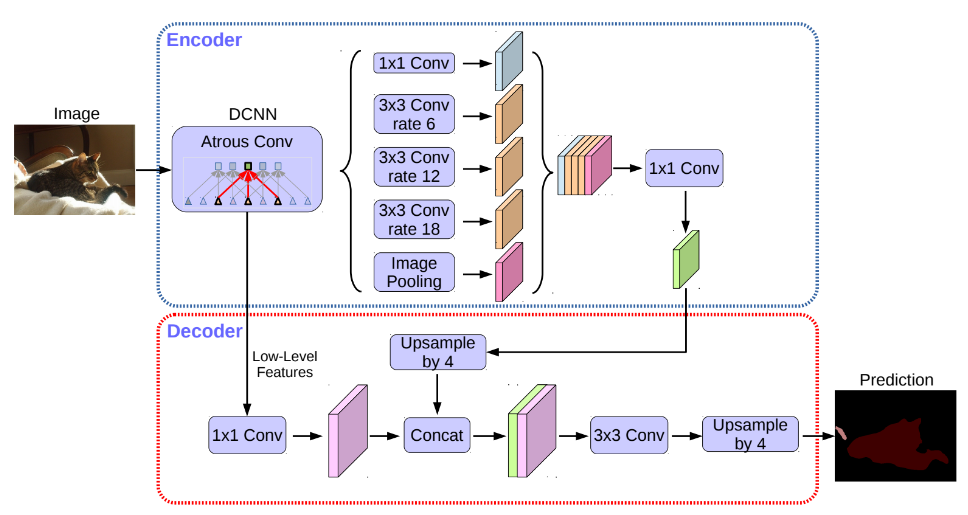

In [ ]:
# Структура иначе изображённая

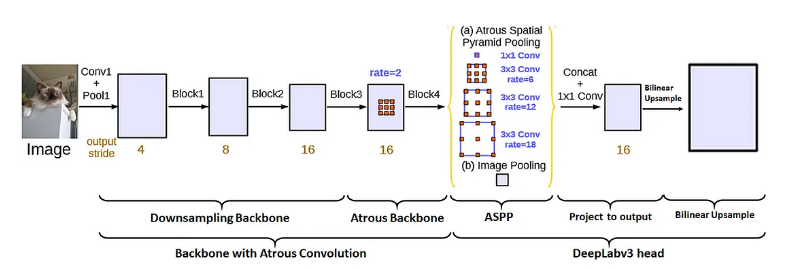

In [ ]:
#@title Functions for DeepLabv3
# https://keras.io/examples/vision/deeplabv3_plus/
# https://medium.com/@itberrios6/deeplabv3-c0c8c93d25a4
tf.keras.backend.clear_session() # сбросить состояния меодели в памяти
################# FUNCTIONS ###############################
### Conv2D func ###
def conv_block(block_input,
               num_filters=16,
               kernel_size=3,
               dilation_rate=1,
               padding='same',
               use_bias=False,
               norm=True,
               activation='relu'):
  x = layers.Conv2D(num_filters,
                    kernel_size=kernel_size,
                    padding='same',
                    use_bias=use_bias,
                    activation=activation)(block_input)
  if norm == True:
    x = layers.BatchNormalization()(x)
  return x

### ASSPP func ###
def ASPP_head(input, filtr=32):
  dims = input.shape
  x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]), strides=None, padding='same')(input)
  x = conv_block(block_input=x, num_filters=filtr, kernel_size=1, padding='same', use_bias=True)
  out_0 = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation='bilinear')(x)
  out_1 = conv_block(block_input=input, num_filters=filtr, kernel_size=1, padding='same', dilation_rate=1)
  out_2 = conv_block(block_input=input, num_filters=filtr, kernel_size=3, padding='same', dilation_rate=6)
  out_3 = conv_block(block_input=input, num_filters=filtr, kernel_size=3, padding='same', dilation_rate=12)
  out_4 = conv_block(block_input=input, num_filters=filtr, kernel_size=3, padding='same', dilation_rate=18)

  x = layers.Concatenate(axis=-1)([out_0, out_1, out_2, out_3, out_4])
  out = conv_block(block_input=x, num_filters=filtr, kernel_size=1, padding='same', dilation_rate=1)
  return out

### Magistral func ###
def Magistral_main(input, filters=[(4,8), (8, 8)], im_size=SET_IM_SIZE + (3,), name='a_'):
  input_l = input
  b = input_l
  inp_reduce=False
  arr_level = []
  # Down chain
  for i in range(len(filters)):
    if i!=0:
      inp_reduce=True
    name = name + f'Bl_{i+1}'
    if i==len(filters)-1:
      name=f'bottom_{i+1}'
    b = block(inp_x=b, filters=filters[i], inp_reduce=inp_reduce, name=name)
  out = b
  return out

In [ ]:
#@title DeepLabV3_Plus
############################ BODY MODEL DeepLabV3 ###################
input = keras.Input(shape=SET_IM_SIZE + (3,), dtype = 'float32')
print(input)

filters_mag1 = [(16, 32), (32, 64), (128, 256)]
filters_mag2 = [(16, 32) ]
filters_mag2_out = 128
filter_ASPP = 128
filters_end = 16

mag2_out = Magistral_main(input=input, filters=filters_mag2, name='a_')
mag2_out = conv_block(block_input=mag2_out, num_filters=filters_mag2_out, kernel_size=1, padding='same', dilation_rate=1)
print('mag2_out :  ', mag2_out)
dims_mag2 = mag2_out.shape
mag1_out = Magistral_main(input=input, filters=filters_mag1, name='b_')
print('mag1_out :  ', mag1_out)

aspp_head_out = ASPP_head(input=mag1_out, filtr=filter_ASPP)
print('ASPP_gen_out :  ', aspp_head_out)
if (aspp_head_out.shape[-3], aspp_head_out.shape[-2]) != (mag2_out.shape[-3], mag2_out.shape[-2]):
  print('Need UpSampling')
  aspp_head_out_up = layers.UpSampling2D(size=(mag2_out.shape[-3] // aspp_head_out.shape[1], mag2_out.shape[-2] // aspp_head_out.shape[2]), interpolation='bilinear')(aspp_head_out)
else:
  print('not need UpSampling')
  aspp_head_out_up = aspp_head_out
print('ASPP_head_out_UP :  ', aspp_head_out_up)

x = layers.Concatenate(axis=-1)([aspp_head_out_up, mag2_out])
x = conv_block(block_input=x, num_filters=filters_end, kernel_size=(3, 3), padding='same', dilation_rate=1)

if (x.shape[-3], x.shape[-2]) != (input.shape[-3], input.shape[-2]):
  print('Need UpSampling')
  x = layers.UpSampling2D(size=(input.shape[-3] // x.shape[1], input.shape[-2] // x.shape[2]), interpolation='bilinear')(x)
  print('After UpSamling :  ', x)
else:
  print('not need UpSampling')


model_out = layers.Conv2D(NUM_CLASSES, (2, 2), padding='same', activation='softmax', name='out_mask')(x)
# x = layers.AveragePooling2D(pool_size=4, padding='same')(model_out)
# model_out = layers.UpSampling2D(size=(input.shape[-3] // x.shape[1], input.shape[-2] // x.shape[2]), interpolation='bilinear')(x)

DeepLabV3 = keras.Model(inputs=input, outputs=model_out)

model_4 = DeepLabV3
model_4.summary()

Tensor("input_31:0", shape=(None, 128, 256, 3), dtype=float32)
mag2_out :   Tensor("batch_normalization_240/cond/Identity:0", shape=(None, 128, 256, 128), dtype=float32)
mag1_out :   Tensor("bottom_3_5_29/cond/Identity:0", shape=(None, 32, 64, 256), dtype=float32)
ASPP_gen_out :   Tensor("batch_normalization_246/cond/Identity:0", shape=(None, 32, 64, 128), dtype=float32)
Need UpSampling
ASPP_head_out_UP :   Tensor("up_sampling2d_61/resize/ResizeBilinear:0", shape=(None, 128, 256, 128), dtype=float32)
not need UpSampling
Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                            

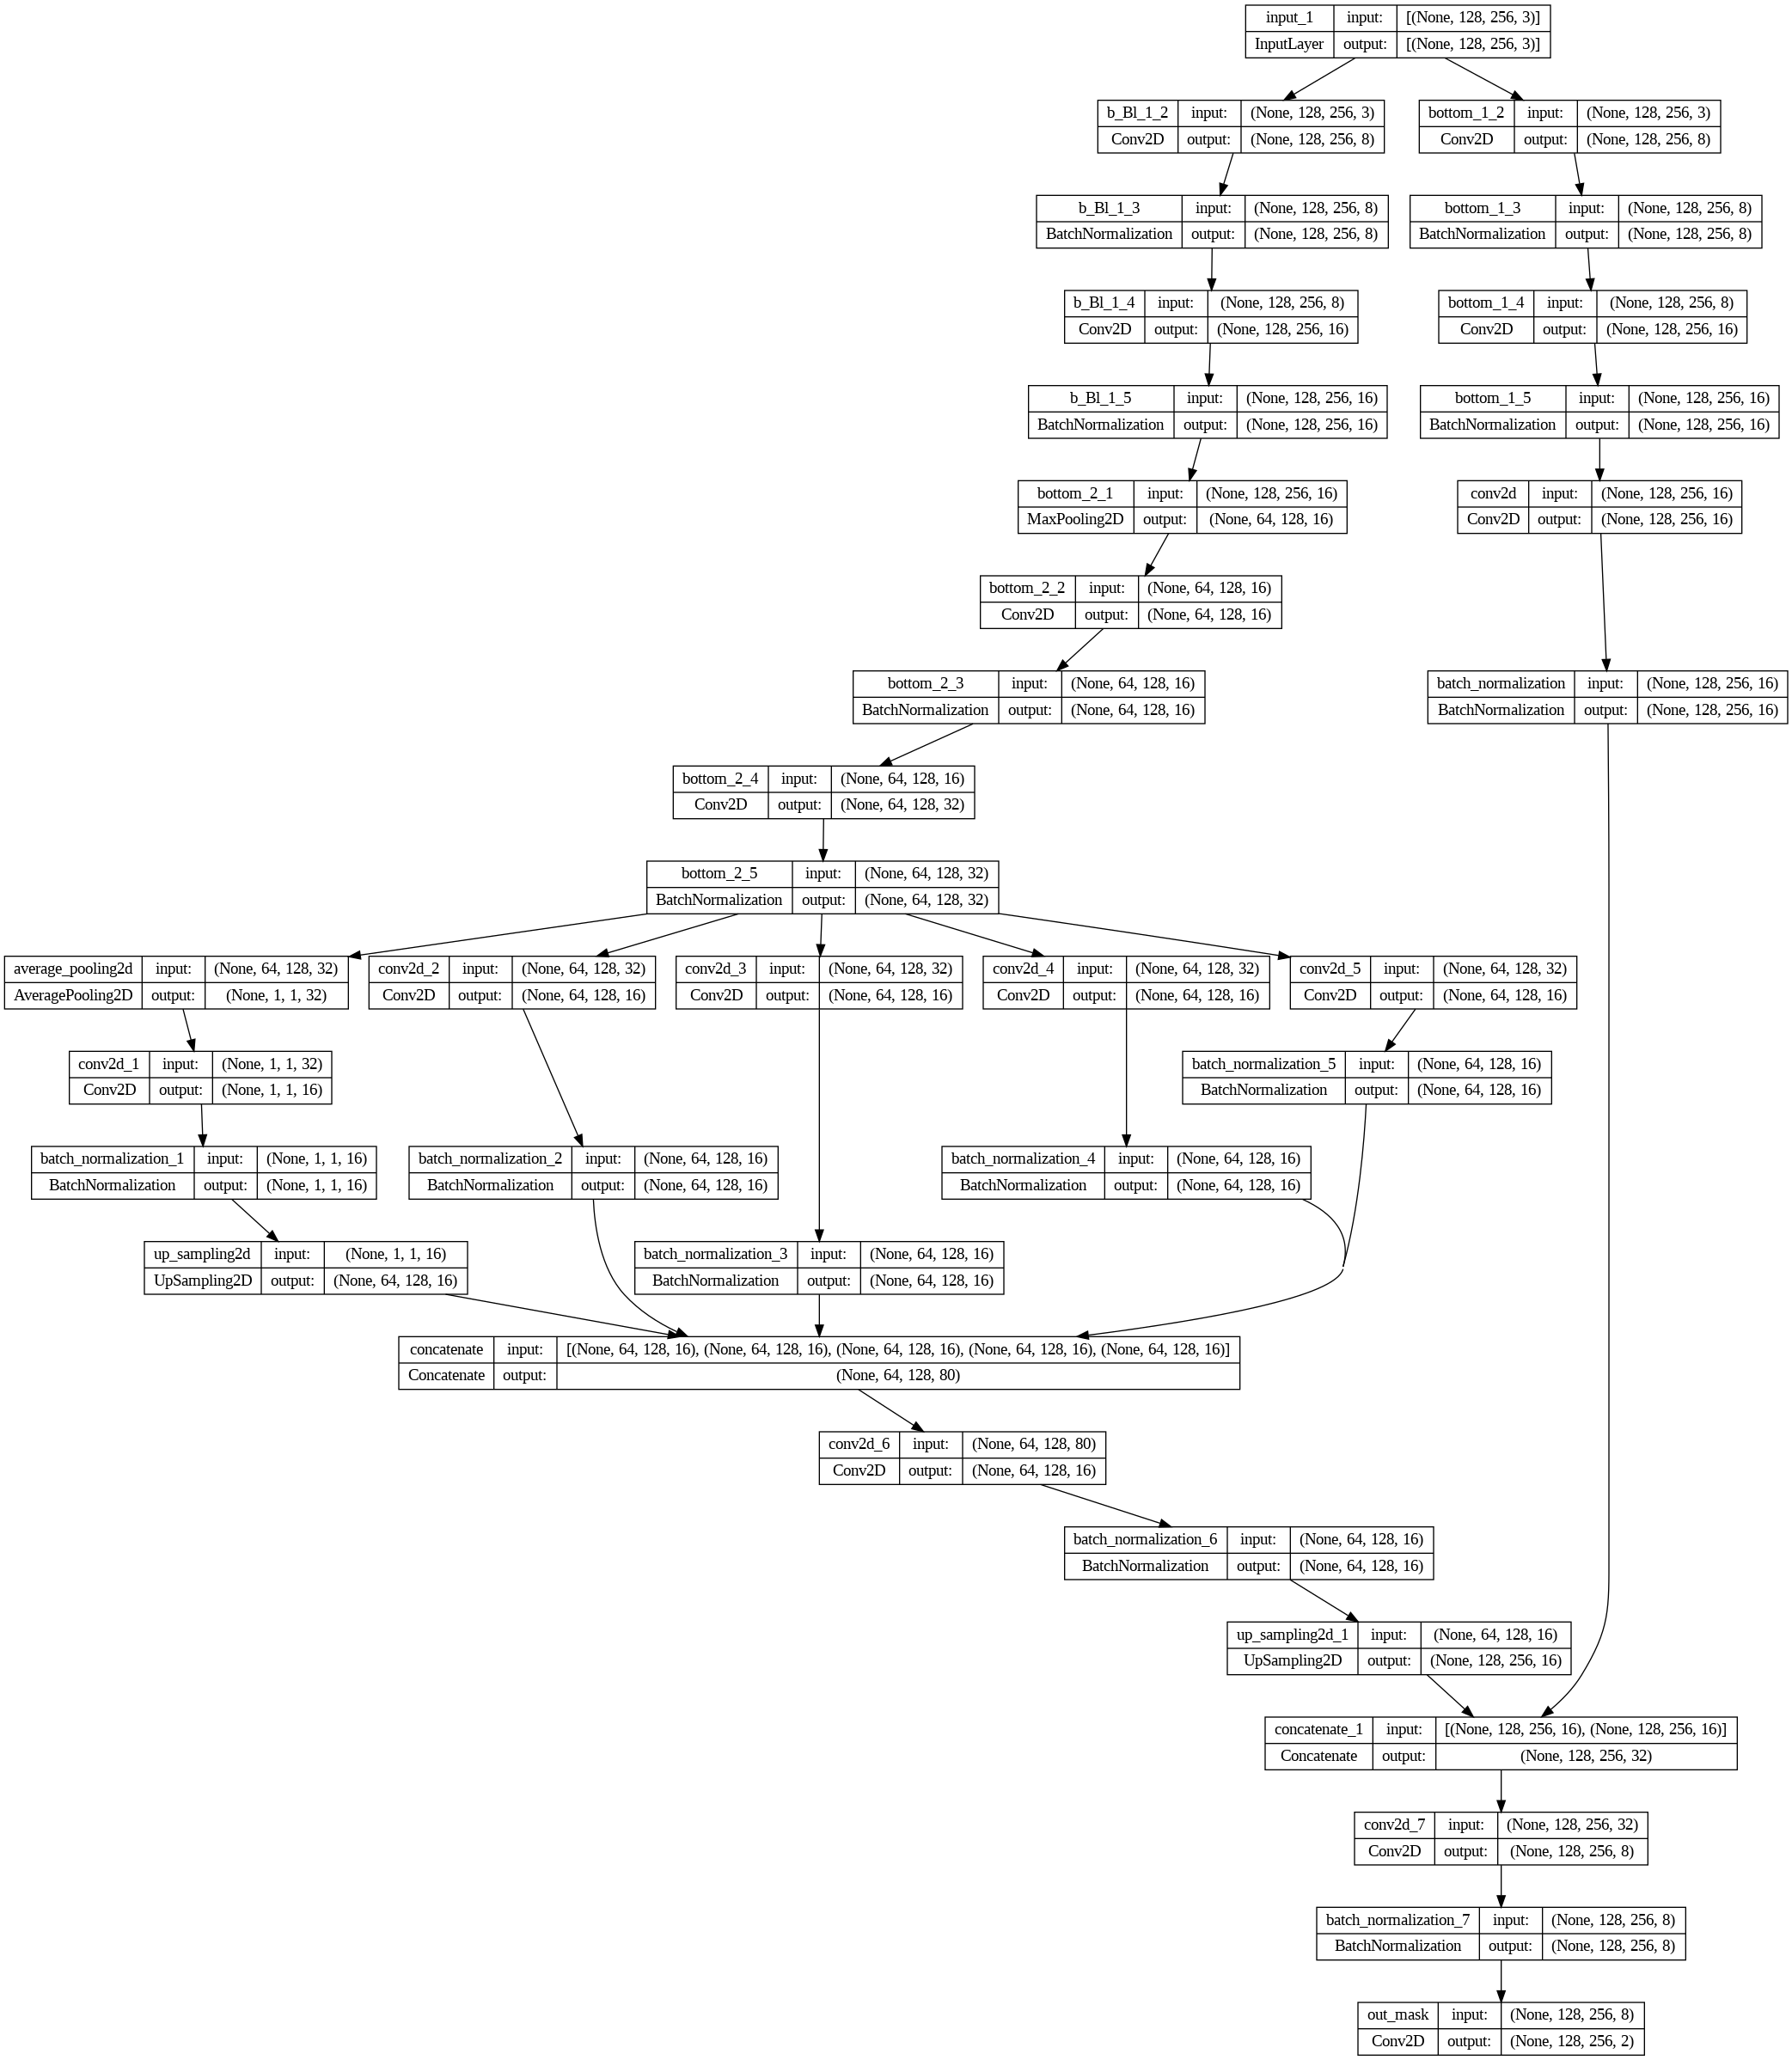

In [ ]:
# Построение графа модели
from keras.utils import plot_model
struct_model_pict = '/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/' + part_str +'/model_struct_DeepLabV3Plus.png'
plot_model(model_4, show_shapes=True, to_file=struct_model_pict)

# **6. TRAINING NN**



In [ ]:
#@title metrics
def f1_score(y_true, y_pred):

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return (2*intersection) / denominator

def jaccard_loss(y_true, y_pred, smooth=100.0):

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return (1 - jac) * smooth

def jaccard_metric(y_true, y_pred, smooth=0.0000001):

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    jac = (intersection + smooth) / (union + smooth)
    return jac

In [ ]:
#@title compilation model
#  Компиляция модели. Настраивает модель Keras Sequential для обучения.
model = model_4
model.compile(optimizer='rmsprop', # Adam rmsprop
              loss='categorical_crossentropy', # categorical_crossentropy jaccard_loss f1_score
              metrics=['accuracy']
             ) #  ['accuracy', f1_score, jaccard_metric]    metrics=['accuracy', f1_score]     tf.keras.metrics.MeanIoU(num_classes=2) MeanIoU(num_classes=2)
# tf.keras.metrics.categorical_crossentropy     metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=(5,))
# model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
#               # Минимизируемая функция потерь
#               loss=keras.losses.SparseCategoricalCrossentropy(),
#               # Список метрик для мониторинга
#               metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Обратные вызовы
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=path_best_model,
                                                  monitor='val_loss',
                                                  save_best_only=True)]
# callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=0.05) ,
#                   keras.callbacks.ModelCheckpoint(filepath='my_model_best_4Classes.h5',
#                                                   monitor='val_loss',
#                                                   save_best_only=True)]

In [ ]:
#@title Init Generators again

###  GEN FOR TRAIN  ###
data_gen_args = dict(rotation_range=10.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     rescale=1./255)
image_datagen = ImageDataGenerator(**data_gen_args) # генератор данных картинок
image_generator = image_datagen.flow_from_directory(
    directory=train_dir,
    color_mode='rgb',
    target_size=SET_IM_SIZE,
    classes=['image'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)
mask_generator = mask_gen(train_dir=train_dir, data_gen_args=data_gen_args, target_size=SET_IM_SIZE, batch_size=BATCH_SIZE, seed=seed)
train_generator = zip(image_generator, mask_generator) # Созданный генератор картинок и масок

###  GEN FOR VALIDATION  ###
data_gen_args_valid = dict(rescale=1./255)
image_datagen_val = ImageDataGenerator(**data_gen_args_valid) # генератор данных картинок
image_generator_val = image_datagen_val.flow_from_directory(
    directory=val_dir,
    color_mode='rgb',
    target_size=SET_IM_SIZE,
    classes=['image'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)
mask_generator_val = mask_gen(train_dir=val_dir, data_gen_args=data_gen_args_valid, target_size=SET_IM_SIZE, batch_size=BATCH_SIZE, seed=seed)
valid_generator = zip(image_generator_val, mask_generator_val) # Созданный генератор картинок и масок

###  GEN FOR TEST  ###
data_gen_args_valid = dict(rescale=1./255)
image_datagen_test = ImageDataGenerator(**data_gen_args_valid) # генератор данных картинок
image_generator_test = image_datagen_test.flow_from_directory(
    directory=test_dir,
    color_mode='rgb',
    target_size=SET_IM_SIZE,
    classes=['image'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)
mask_generator_test = mask_gen(train_dir=test_dir, data_gen_args=data_gen_args_valid, target_size=SET_IM_SIZE, batch_size=BATCH_SIZE, seed=seed)
test_generator = zip(image_generator_test, mask_generator_test) # Созданный генератор картинок и масок


Found 4096 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
Found 512 images belonging to 1 classes.


In [ ]:
#@title Run training
# Запуск процесса обучения
history = model.fit(train_generator,
                    steps_per_epoch=62,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=18,
                    callbacks=callbacks_list
                    ) # validation_data=valid_generator, validation_steps=10,

Found 4096 images belonging to 1 classes.
Epoch 1/30
62/62 [==============================] - ETA: 0s - batch: 30.5000 - size: 32.0000 - loss: 0.1834 - accuracy: 0.9266Found 300 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


62/62 [==============================] - 110s 1s/step - batch: 30.5000 - size: 32.0000 - loss: 0.1834 - accuracy: 0.9266 - val_loss: 0.6786 - val_accuracy: 0.6357
Epoch 2/30
62/62 [==============================] - 47s 758ms/step - batch: 30.5000 - size: 32.0000 - loss: 0.2339 - accuracy: 0.9170 - val_loss: 0.9663 - val_accuracy: 0.6347
Epoch 3/30
62/62 [==============================] - 52s 842ms/step - batch: 30.5000 - size: 32.0000 - loss: 0.1811 - accuracy: 0.9408 - val_loss: 0.6545 - val_accuracy: 0.6382
Epoch 4/30
62/62 [==============================] - 53s 860ms/step - batch: 30.5000 - size: 32.0000 - loss: 0.1900 - accuracy: 0.9347 - val_loss: 0.4091 - val_accuracy: 0.8398
Epoch 5/30
62/62 [==============================] - 53s 855ms/step - batch: 30.5000 - size: 32.0000 - loss: 0.1796 - accuracy: 0.9393 - val_loss: 0.4193 - val_accuracy: 0.8439
Epoch 6/30
62/62 [==============================] - 52s 845ms/step - batch: 30.5000 - size: 32.0000 - loss: 0.1790 - accuracy: 0.9388

### **6.1 Learning Analysis**

In [ ]:
# Имеющиеся ключи истории обучения
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


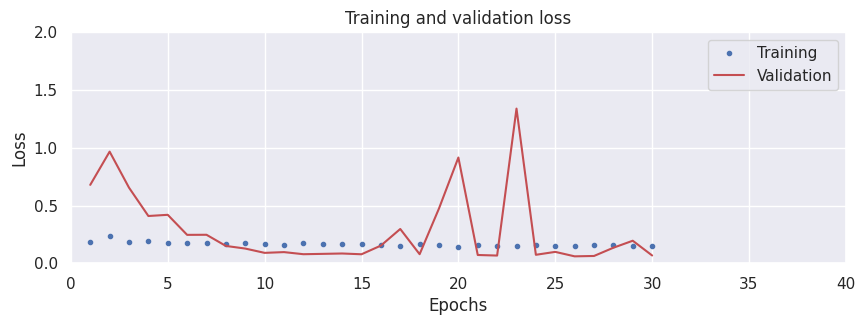

In [ ]:
# Посроение графика ПОТЕРЬ на этапе обучения и проверки
plt.figure(figsize=(10,3))
loss = history.history['loss'] # выбираем по ключу Loss данные о потерях при обучении
val_loss = history.history['val_loss'] # выбираем по ключу  val_Loss данные о потерях при обучении
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b.', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, 40)
plt.ylim(0, 2)
plt.show()

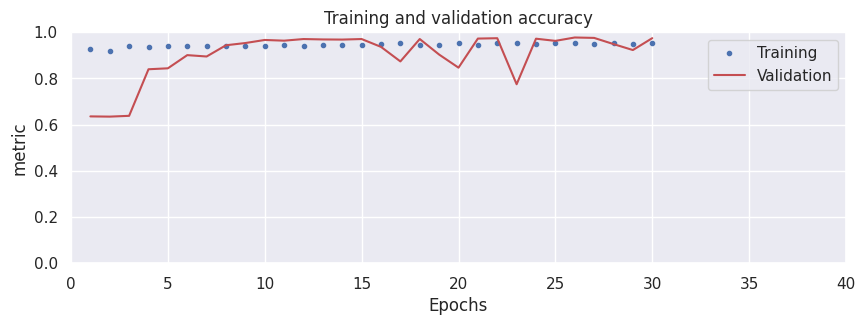

In [ ]:
# Посроение графика ТОЧНОСТИ на этапе обучения и проверки
# acc = history.history['mean_io_u_2']
fun = 'accuracy' #'accuracy' f1_score
fun_val = 'val_accuracy' #'val_accuracy' val_f1_score
acc = history.history[fun]
plt.figure(figsize=(10,3))
# val_acc = history.history['val_mean_io_u_2']
val_acc = history.history[fun_val]
plt.plot(epochs, acc, 'b.', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('metric')
plt.xlim(0.0, 40)
plt.ylim(0.0, 1)
plt.legend()
plt.show()

In [ ]:
# Отключение сесии если нужно пойти спать )
# SET variable True:
turn_off = True
if turn_off == True:
  runtime.unassign()   # ЕСЛИ НУЖНО отключение от сесии, дабы не использовать GPU вхолостую когда сеть обучилась и машина простаивает

# **7. Loading the best model and analysis**

In [ ]:
# Загрузка лучшей модели с диска (при необходимости)
model = models.load_model('/content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/variant_5/U_net_v1.h5') # my_model_Segment
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data_frame (InputLayer)        [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Bl_1_2 (Conv2D)                (None, 128, 256, 16  208         ['data_frame[0][0]']             
                                )                                                                 
                                                                                                  
 Bl_1_3 (BatchNormalization)    (None, 128, 256, 16  64          ['Bl_1_2[0][0]']                 
                                )                                                             

In [ ]:
#@title Estimating Model Accuracy on Test Data
# Оценка точности сегментации на тестовых данных

model.compile(optimizer='rmsprop', # Adam rmsprop
              loss='categorical_crossentropy', # categorical_crossentropy jaccard_loss f1_score
              metrics=['accuracy'])

test_loss, test_acc = model.evaluate(test_generator, steps=16)
print('По тестовым модельным данным: ')
print(f'Потери на тестовых данных:   {test_loss}')
print(f'Точность на тестовых данных: {test_acc} , где 1 - это 100 %')

Found 512 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


По тестовым модельным данным: 
Потери на тестовых данных:   0.1316861710511148
Точность на тестовых данных: 0.951464831829071 , где 1 - это 100 %


In [ ]:
#@title Adding a mask smoothing function to the model

# ЕСЛИ НУЖНО !!!
# Добаляет в модель пространственное усреднение по среднему из выбранного окна для сглаживания маски от вкраплений посреди междурядья
def average_mask(input, pool_size=(2, 2), im_size=SET_IM_SIZE):

  x = layers.AveragePooling2D(pool_size=pool_size, padding='same', name='end')(input)
  model_out = layers.UpSampling2D(size=(im_size[0] // x.shape[1], im_size[1] // x.shape[2]), interpolation='bilinear', name='endi')(x)
  print((im_size[0] // x.shape[1], im_size[1] // x.shape[2]))
  return model_out
# Внимание нужно указывать реальные имена слоёв, смотри имена слоёв в модели, которая распечатаны методом summary
x = model.get_layer("out_mask").output # берём выход указанного слоя
input = model.get_layer("data_frame").output # берём выход указанного слоя data_frame  input_1
model_out = average_mask(input=x, pool_size=(2, 2)) # добавляем к предыдущему выходу модели усреднение с выбранным ядром
model = keras.Model(inputs=input, outputs=model_out) # синтез новой модели с добавленным усреднением
model.summary()

(2, 2)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data_frame (InputLayer)        [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Bl_1_2 (Conv2D)                (None, 128, 256, 16  208         ['data_frame[0][0]']             
                                )                                                                 
                                                                                                  
 Bl_1_3 (BatchNormalization)    (None, 128, 256, 16  64          ['Bl_1_2[0][0]']                 
                                )                                                    

## **7.1 Model prediction for untagged photos**

In [ ]:
# Оценка работы модели по данных без масок. Визуальная оценка масок
# Сегментация тестовых данных - фото с поля
# SET Откуда и сколько прочитать:
real_dir = '/content/sample_data/variant_5/'
dir_name_into = 'internet_128_256_v2'  # vid3_128_256_v2
batch_size = 32*10
#### Подготовка генератора данных
data_gen_args_real = dict(rescale=1./255)
image_datagen_real = ImageDataGenerator(**data_gen_args_real) # генератор данных картинок
print('Validation directory : ', real_dir)
###
image_generator_real = image_datagen_real.flow_from_directory(
    directory=real_dir,
    color_mode='rgb',
    target_size=SET_IM_SIZE,
    classes=[dir_name_into],   # image
    class_mode=None,
    batch_size=batch_size,
    seed=seed
)   # grayscale
real_generator = image_generator_real

# Прочиать картинки генератором
chv = next(real_generator)
im_batchv = chv
print(im_batchv.shape, ' Image batch')
# Получение оценок потерь и точности настроенной модели на тестовых данных
# прогноз с оценкой времени прогноза блока данных
%time y_pred = model.predict(im_batchv, verbose=1)

Validation directory :  /content/sample_data/variant_5/
Found 56 images belonging to 1 classes.
(56, 128, 256, 3)  Image batch
CPU times: user 18.1 s, sys: 4.64 s, total: 22.7 s
Wall time: 22.9 s


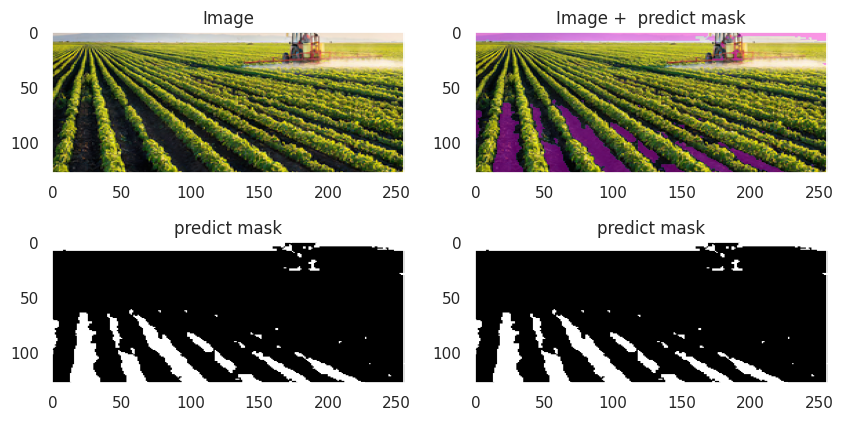

In [ ]:
kadr = 25 # Выбор кадра для просмотра и визуальной оценки
level = 0.6 # Порого отнесени пиксеоей маски к разным классам (каждый пиксеть масик - это вероятность отнесения к классу 1)

image_m = im_batchv[kadr,:,:,:]
mask_m  = y_pred[kadr,:,:,0].copy()
mask_m[mask_m <  level] = 0
mask_m[mask_m >= level] = 1
# res = mix_im_mask(image_m, mask_m)

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].imshow(image_m, aspect=0.8);
ax[0, 0].set_title('Image')
ax[0, 0].grid(False) #

ax[0, 1].imshow(image_m, aspect=0.8);
ax[0, 1].set_title('Image +  predict mask')
ax[0, 1].grid(False) #
ax[0, 1].imshow(mask_m, cmap='cool', aspect=0.8, alpha=0.35 * mask_m) #

ax[1, 0].imshow(mask_m, cmap='gray', aspect=0.8) #
ax[1, 0].set_title('predict mask')
ax[1, 0].grid(False) #
ax[1, 1].imshow(mask_m, cmap='gray', aspect=0.8) #
ax[1, 1].set_title('predict mask')
ax[1, 1].grid(False) #
# cv2.imwrite('/content/sample_data/' +"1.png", res)

In [ ]:
!rm -rf '/content/sample_data/save_1/'

In [ ]:
# !mkdir '/content/sample_data/save_1/'
!mkdir '/content/sample_data/save_1/'

In [ ]:
for i in range(im_batchv.shape[0]):
  image_m = im_batchv[i,:,:,:]
  image_m = (image_m * 255).astype('uint8')
  mask_m  = y_pred[i,:,:,0].copy()
  mask_m[mask_m <  level] = 0
  mask_m[mask_m >= level] = 1
  mask_m = mask_m.astype('uint8')
  mask_rgb = to_mask_color(mask_m)
  mix = cv2.addWeighted(image_m, 0.8, mask_rgb, 0.2, 0)
  cv2.imwrite('/content/sample_data/save_1/' + f"{i}.png", mix)
  cv2.imwrite('/content/sample_data/save_1/' + f"mask_{i}.png", mask_rgb)


In [ ]:
!zip -r '/content/sample_data/internet_128_256_v2.zip' '/content/sample_data/save_1/'

  adding: content/sample_data/save_1/ (stored 0%)
  adding: content/sample_data/save_1/mask_23.png (deflated 56%)
  adding: content/sample_data/save_1/mask_18.png (deflated 10%)
  adding: content/sample_data/save_1/40.png (deflated 0%)
  adding: content/sample_data/save_1/mask_26.png (deflated 79%)
  adding: content/sample_data/save_1/mask_19.png (deflated 21%)
  adding: content/sample_data/save_1/18.png (deflated 0%)
  adding: content/sample_data/save_1/mask_8.png (deflated 42%)
  adding: content/sample_data/save_1/16.png (deflated 0%)
  adding: content/sample_data/save_1/mask_20.png (deflated 18%)
  adding: content/sample_data/save_1/mask_44.png (deflated 79%)
  adding: content/sample_data/save_1/47.png (deflated 0%)
  adding: content/sample_data/save_1/38.png (deflated 0%)
  adding: content/sample_data/save_1/50.png (deflated 0%)
  adding: content/sample_data/save_1/23.png (deflated 0%)
  adding: content/sample_data/save_1/mask_35.png (deflated 20%)
  adding: content/sample_data/sav

In [ ]:
!cp  '/content/sample_data/internet_128_256_v2.zip' /content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/variant_5/

In [ ]:
# !cp -r /content/sample_data/save_1 /content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/variant_5/